In [2]:
#%%
#Import dependencies
from scipy.ndimage import rotate
import numpy as np
#%matplotlib notebook
import nibabel as nib
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
#import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign
image_file = '../visium_data/sccanals26/A1_mod.jpg'
V = plt.imread(image_file)
Vnorm = STalign.normalize(V)
I = Vnorm.transpose(2,0,1)
I=I[0:200,1500:4200,400:3000]

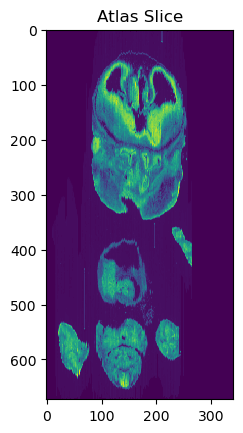

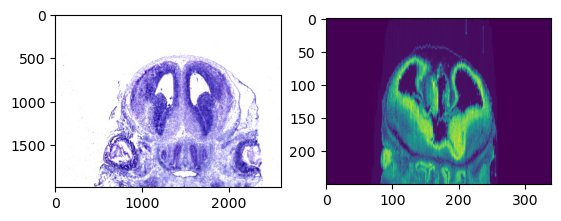

In [18]:
YI= np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
# # fig,ax = plt.subplots(1,2)
theta_deg = 90
theta_deg2 = -50
# extentA = STalign.extent_from_x((YJ,XJ))
X_=np.arange(0, 1000, 1)
Y_=np.arange(0, 1000, 1)
# W=J[:,:,:]
xI = [Y_,X_]
# J = W[None]/np.mean(np.abs(W))
#vol,hdr = nrrd.read('../E13-5_MRI_34um/atlasVolume.nrrd',index_order='F')
import SimpleITK as sitk
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
A = ct_scan.transpose(2,1,0) 
slice = 251
theta_deg = 0
fig,ax = plt.subplots()
ax.imshow(rotate(A[slice], angle=theta_deg),interpolation='none')
ax.set_title('Atlas Slice')
J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:250,:]
# I = np.concatenate((I,(I-np.mean(I))**2))
 
YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 
fig,ax = plt.subplots(1,2)
extentJ = STalign.extent_from_x((YJ,XJ))
#extentA = STalign.extent_from_x(xA[1:])
extentI = STalign.extent_from_x((YI,XI))
theta_deg = -(90+30)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
fig.canvas.draw()  
np.savez('../test/model',x=XI,y=YI,I=I)
np.savez('../test/visum', x=XJ,y=YJ,I=J[0:1])

Text(0.5, 1.0, 'target with pointsJ')

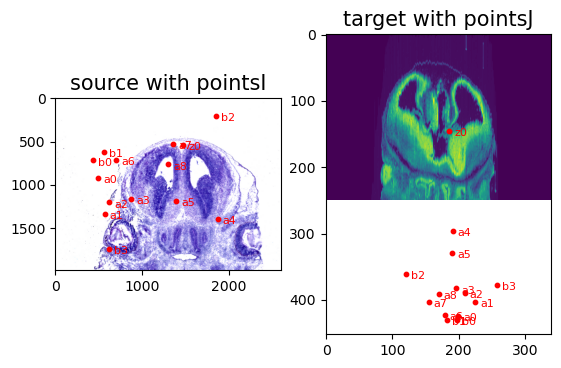

In [6]:
pointsIlist = np.load('../test/model_points.npy', allow_pickle=True).tolist()
# print(pointsIlist)
pointsJlist = np.load('../test/visum_points.npy', allow_pickle=True).tolist()
# print(pointsJlist)
pointsI = []
pointsJ = []

YI = (np.array(range(I.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = (np.array(range(I.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])
I=I
J = np.vstack((J,J,J)) 
pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)
fig,ax = plt.subplots(1,2)
extentJ = STalign.extent_from_x((YJ,XJ))
#extentA = STalign.extent_from_x(xA[1:])
extentI = STalign.extent_from_x((YI,XI))
theta_deg = -(90+30)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)
    
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

In [8]:
I = STalign.normalize((I).astype(np.float64))
# compute initial affine transformation from points
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')
L,T = STalign.L_T_from_points(pointsI,pointsJ)

sigmaA = 0.12 #standard deviation of artifact intensities
sigmaB = 0.12 #standard deviation of background intensities
sigmaM = 0.12#standard deviation of matching tissue intenities
# muA = torch.tensor([3,3,3],device='cpu') #average of artifact intensities
# muB = torch.tensor([0,0,0],device='cpu') #average of background intensities
# initialize variables

theta0 = (np.pi/180)*theta_deg


extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))


# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
   
#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points


1-10


C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Albert\Documents\GitHub\STalign\docs\notebooks\../../STalign\STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


3.327654652802203


C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\torch\utils\_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


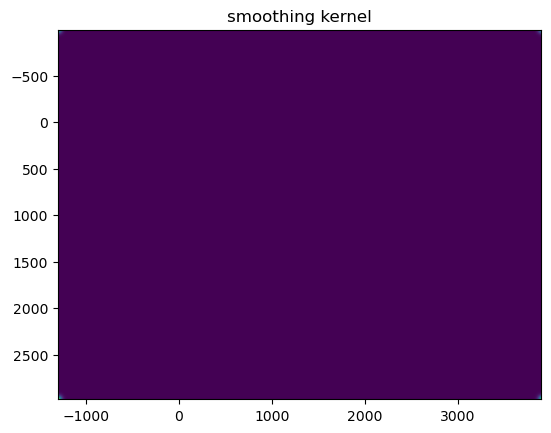

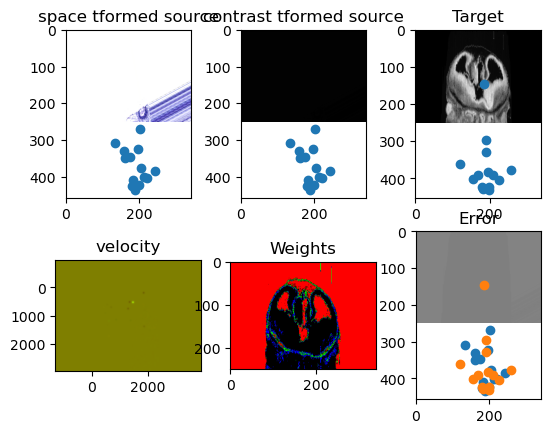

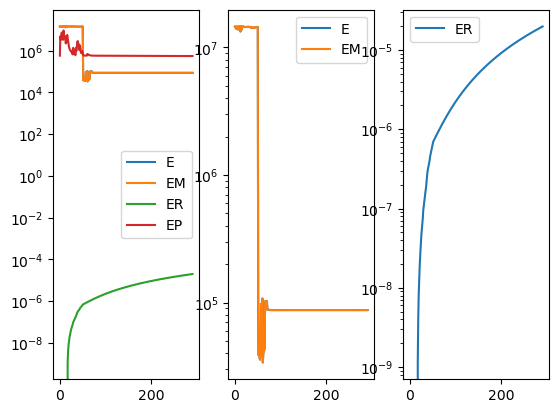

In [10]:
xI=[YI,XI]
xJ=[YJ,XJ]
err=10
for i in range(1,2,1):
    for j in range(10,20,10):
        torch.cuda.empty_cache()
        print(str(i)+"-"+str(j))
        transform = STalign.LDDMM(
        xI,I,xJ,J,
        L=L,T=T,
        pointsI= pointsI,
        pointsJ=pointsJ,
        nt=i,
        niter=300,
        diffeo_start = 16,
        device='cuda:0',
        a=j,
        sigmaP = 2e-1,
        epL= 5e-11,
        epT= 5e-3,
        epV= 5e-2,
        sigmaA = sigmaA, #standard deviation of artifact intensities
        sigmaB = sigmaB, #standard deviation of background intensities
        sigmaM = sigmaM, #standard deviation of matching tissue intenities
        # muA = muA, #average of artifact intensities
        # muB = muB #average of background intensities
        )
        A = transform['A']
        v = transform['v']
        xv = transform['xv']
        phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
        if phiI.is_cuda:
            phiI = phiI.cpu()
        mse =((J - phiI.numpy())**2).mean(axis=None)
        print(mse)
        if mse <err:
            err=mse
            param=[i,j]

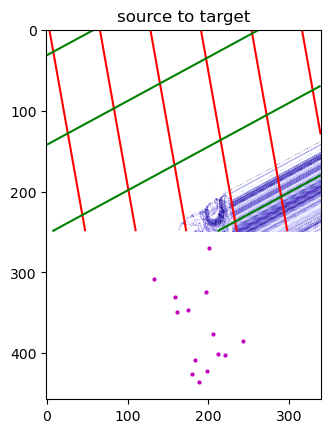

In [10]:




A = transform['A']
v = transform['v']
xv = transform['xv']
#Xs = transform['Xs']

WM = transform['WM'].tolist()
WB = transform['WB'].tolist()
WA = transform['WA'].tolist()
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phiipointsI = STalign.transform_points_source_to_target(xv,v,A,pointsI)

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()
if phiipointsI.is_cuda:
    phiipointsI = phiipointsI.cpu()


# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)

ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),s=4,c="m")

mse = ((pointsJ - phiipointsI.numpy())**2).mean(axis=None)
mse =((J - phiI.numpy())**2).mean(axis=None)

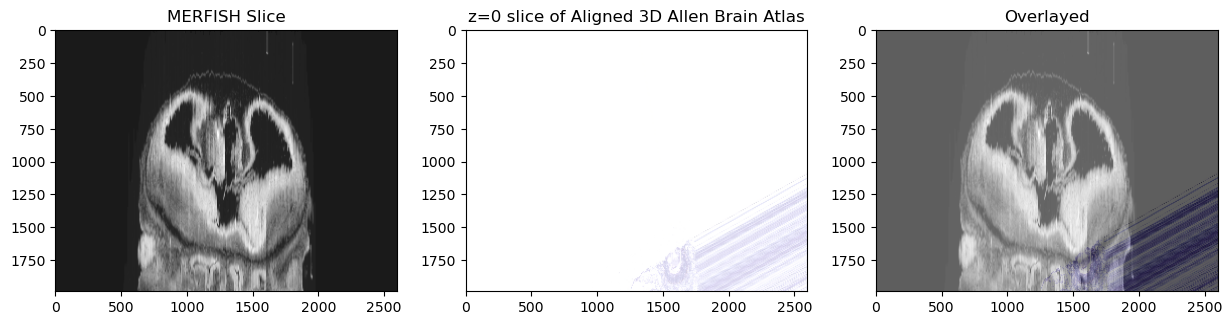

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'After alignment aligned source and target with aligned pointsI and pointsJ')

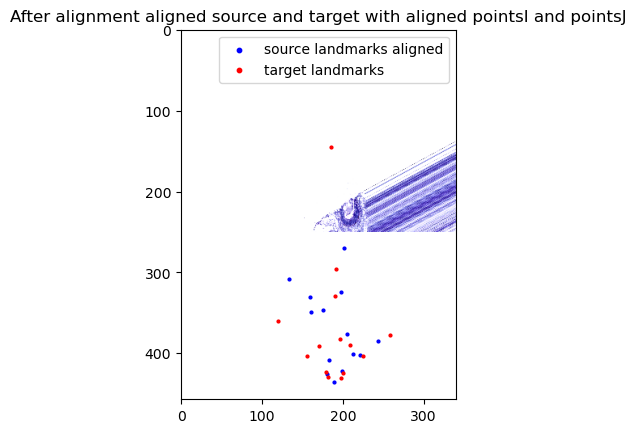

In [11]:
import matplotlib as mpl
It = torch.tensor(I,device='cpu',dtype=torch.float64)
AI = STalign.transform_image_source_with_A(A,xI,I,xJ)

Jt = torch.tensor(J,device='cpu',dtype=torch.float64)
Ishow_target = Jt.permute(1,2,0).cpu()/torch.max(Jt).item()


fig,ax = plt.subplots(1,3, figsize=(15,5))
ax0 = ax[0].imshow(Ishow_target.squeeze(), extent=extentI, cmap = mpl.cm.Blues,alpha=0.9)
ax[0].set_title('MERFISH Slice')
ax1 = ax[1].imshow(AI.permute(1,2,0).cpu().squeeze(), extent=extentI, cmap = mpl.cm.Reds,alpha=0.2)
ax[1].set_title('z=0 slice of Aligned 3D Allen Brain Atlas')
ax2 = ax[2].imshow(Ishow_target.squeeze(), extent=extentI, cmap = mpl.cm.Blues,alpha=0.9)
ax2 = ax[2].imshow(AI.permute(1,2,0).cpu().squeeze(), extent=extentI, cmap = mpl.cm.Reds,alpha=0.3)
ax[2].set_title('Overlayed')

plt.show()
#%%
import matplotlib as mpl
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ,alpha=1)

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ, cmap = mpl.cm.Reds,alpha =1)
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="blue", label='source landmarks aligned', s=4)

ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=4)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ')

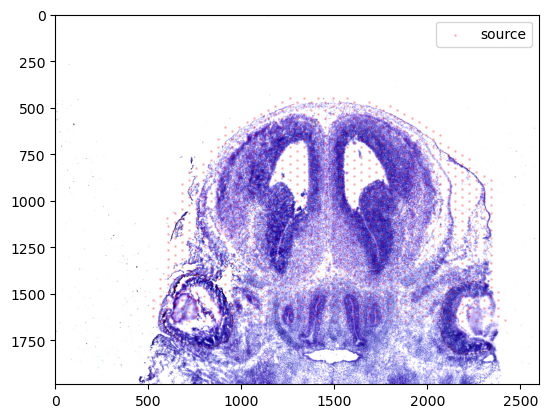

In [15]:
#I=I[0:200,1500:4200,400:3000]
fname = '../visium_data/sccanals26/A1_tissue_positions.csv'
df1 = pd.read_csv(fname)
df1=df1[df1["in_tissue"]==1]
df1=df1[df1["pxl_col_in_fullres"]>400]
df1=df1[df1["pxl_col_in_fullres"]<3000]
df1=df1[df1["pxl_row_in_fullres"]>1500]
df1=df1[df1["pxl_row_in_fullres"]<4200]

# get cell centroid coordinates
xI = (np.array(df1['pxl_col_in_fullres']-400)).astype(np.float64)
yI = (np.array(df1['pxl_row_in_fullres']-1500)).astype(np.float64)
test = Vnorm.transpose(2,0,1)
test=test[0:200,1500:4200,400:3000]
# plot
fig,ax = plt.subplots()
ax.imshow(test.transpose(1,2,0))
ax.scatter(xI,yI,c='red',s=1,alpha=0.2, label='source')
ax.legend(markerscale = 1)
ax.set_aspect('equal')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'After alignment aligned source and target with aligned pointsI and pointsJ')

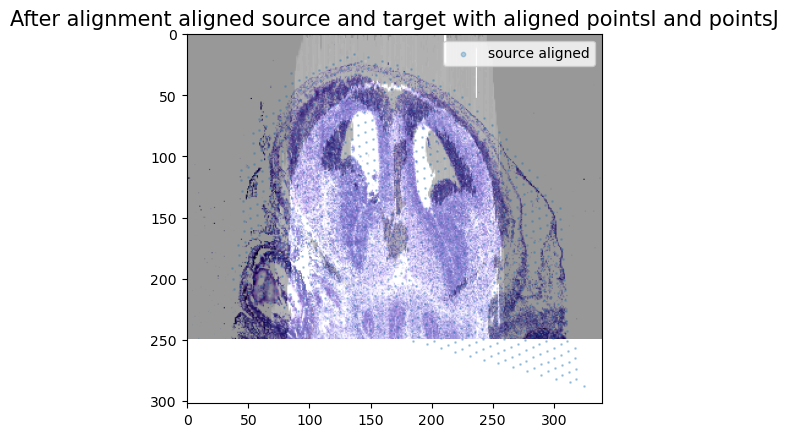

In [17]:
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ,alpha=1)

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ, cmap = mpl.cm.Reds,alpha =0.6)

ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.3, label = 'source aligned')

ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
    
ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ', fontsize=15)

In [11]:
volume = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(volume)

In [13]:
ct_scan.shape

(340, 673, 552)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AttributeError: 'Image' object has no attribute 'transpose'

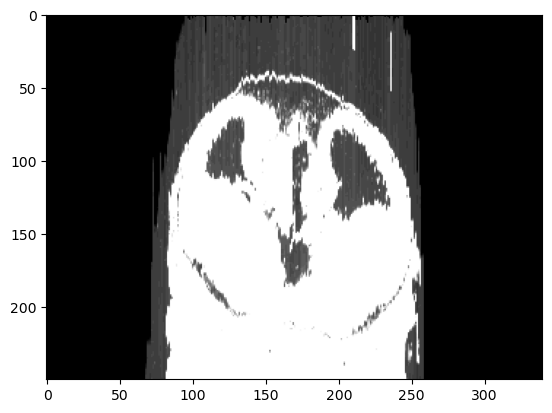

In [15]:
gen=gen[:,:250,:]
fig,ax = plt.subplots()
ax.imshow((J).transpose(1,2,0),extent=extentJ,alpha=1)
ax.imshow((gen).transpose(1,2,0),extent=extentJ,alpha=0.6)

14.221929


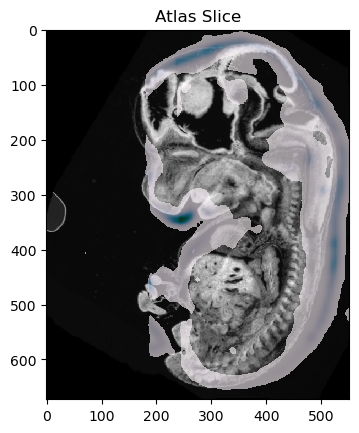

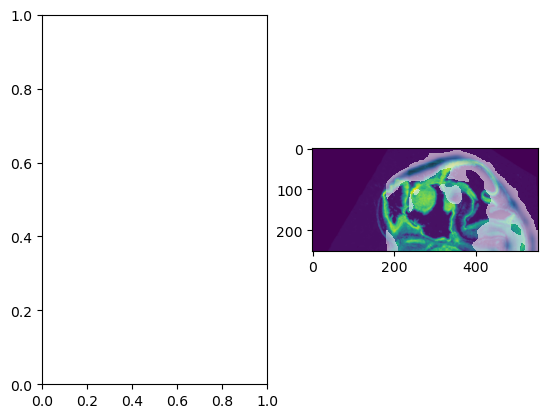

In [17]:
import SimpleITK as sitk
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
A = ct_scan.transpose(0,1,2) 
slice = 162
theta_deg = 0
gen = sitk.ReadImage("./gen-download/gen_list/Zmat4/test.mhd")
total=sitk.Resample(gen,volume)
gen = sitk.GetArrayFromImage(total)
print(np.max(gen))
gen1 = gen.transpose(0,1,2) 
gen1 = np.ma.masked_where(gen1 < .1, gen1)
gen = (gen1[slice][None] / np.mean(np.abs(gen1[slice]),keepdims=True)).astype(np.float64)
fig,ax = plt.subplots()
ax.imshow(rotate(A[slice], angle=theta_deg),interpolation='none',cmap='gray')

ax.imshow((gen[0:1].transpose(1,2,0).squeeze()),cmap='PuBuGn',alpha =0.6) 
ax.set_title('Atlas Slice')
gen = (gen1[slice][None] / np.mean(np.abs(gen1[slice]),keepdims=True)).astype(np.float64)


J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:250,:]
gen=gen[:,:250,:]

 
YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 
fig,ax = plt.subplots(1,2)
extentJ = STalign.extent_from_x((YJ,XJ))

theta_deg = -(90+30)

ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
ax[1].imshow((gen[0:1].transpose(1,2,0).squeeze()), extent=extentJ,cmap='PuBuGn',alpha =0.6) 
fig.canvas.draw()  


In [19]:
from os import listdir
from os.path import isfile, join,isdir
mypath="./gen-download/gen_list"
onlyfiles = [f for f in listdir(mypath) if isdir(join(mypath, f))]

In [21]:
onlyfiles=random.sample(onlyfiles,10)

NameError: name 'random' is not defined

./gen-download/gen_list/Hcrtr2/energy.mhd
./gen-download/gen_list/Aldh4a1/energy.mhd
./gen-download/gen_list/Fgf15/energy.mhd
./gen-download/gen_list/Fgfr2/energy.mhd
./gen-download/gen_list/Csnk1g2/energy.mhd
./gen-download/gen_list/Irx1/energy.mhd
./gen-download/gen_list/Myc/energy.mhd
./gen-download/gen_list/Foxg1/energy.mhd
./gen-download/gen_list/Cdh11/energy.mhd
./gen-download/gen_list/Fgf16/energy.mhd


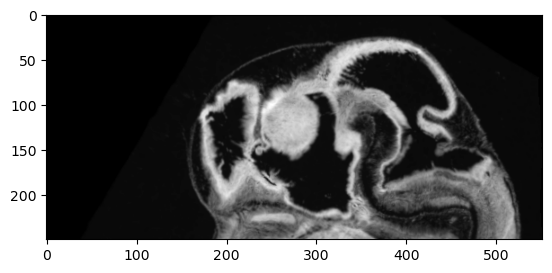

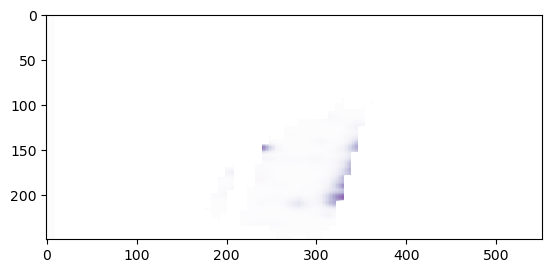

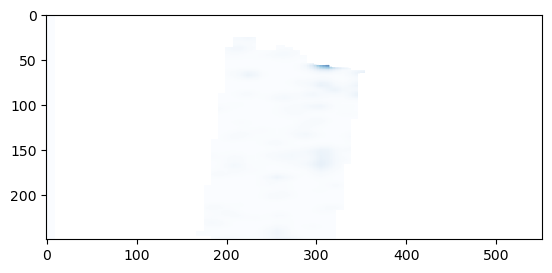

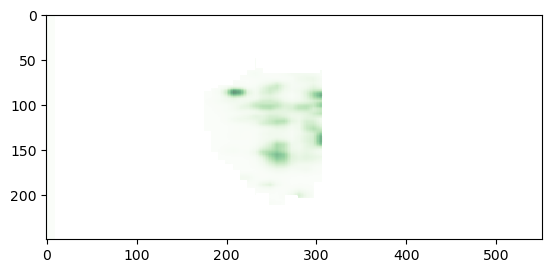

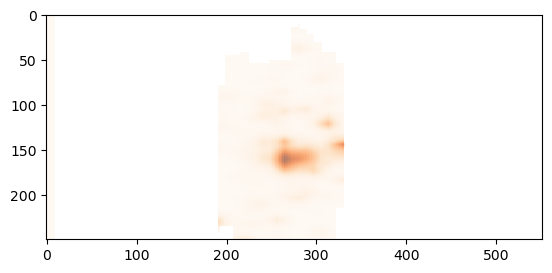

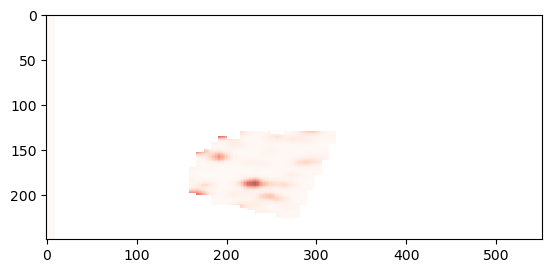

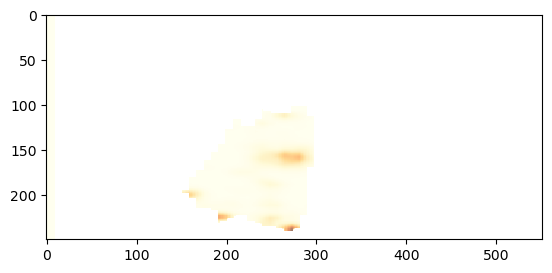

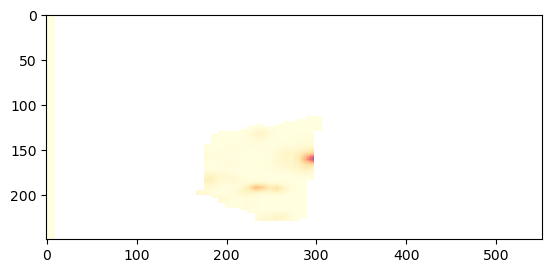

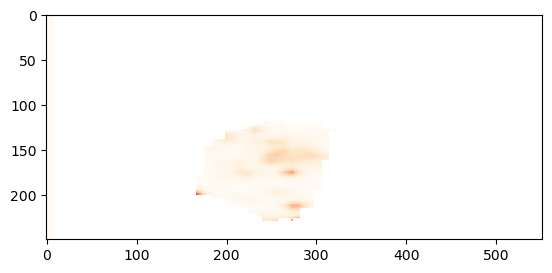

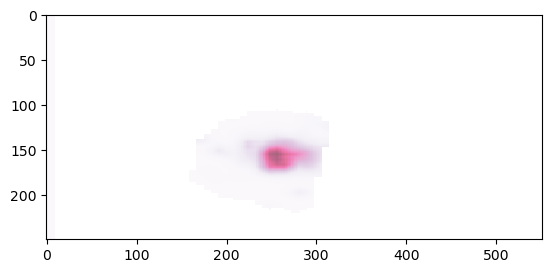

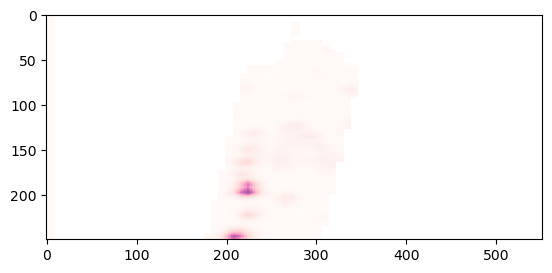

In [238]:
colors=[ 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
A = ct_scan.transpose(0,1,2) 
J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
slice = 162
theta_deg = 0
fig,ax = plt.subplots()

J=J[:,:250,:]
YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 
extentJ = STalign.extent_from_x((YJ,XJ))
# extentA = STalign.extent_from_x(xA[1:])
ax.imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ,cmap='gray')
for i in range(len(onlyfiles)):
    files=listdir(mypath+"/"+onlyfiles[i])
    for j in files:
        if ".mhd" in j :
            fig,ax = plt.subplots()
            print(mypath+"/"+onlyfiles[i]+"/"+j)
            gen = sitk.ReadImage(mypath+"/"+onlyfiles[i]+"/"+j)
            total=sitk.Resample(gen,volume)
            gen = sitk.GetArrayFromImage(total)
            gen1 = gen.transpose(1,2,0) 
            gen1 = np.ma.masked_where(gen1 < 0., gen1)
            gen = (gen1[slice][None] / np.mean(np.abs(gen1[slice]),keepdims=True)).astype(np.float64)
            gen=gen[:,:250,:]
            ax.imshow((gen1[0:1].transpose(1,2,0).squeeze()),interpolation='none', extent=extentJ,alpha =0.6,cmap=colors[i])
            

In [154]:
listdir(mypath+"/"+onlyfiles[0])

['data_set.xml', 'energy.mhd', 'energy.raw']

In [27]:
gen = sitk.ReadImage("./gen-download/gen_list/Fgf15/energy.mhd")
total=sitk.Resample(gen,volume)
gen = sitk.GetArrayFromImage(total)
gen1 = gen.transpose(1,2,0) 
gen1 = np.ma.masked_where(gen1 < 0., gen1)
gen = (gen1[slice][None] / np.mean(np.abs(gen1[slice]),keepdims=True)).astype(np.float64)
gen=gen[:,:250,:]

In [31]:
gen.shape()

TypeError: 'tuple' object is not callable

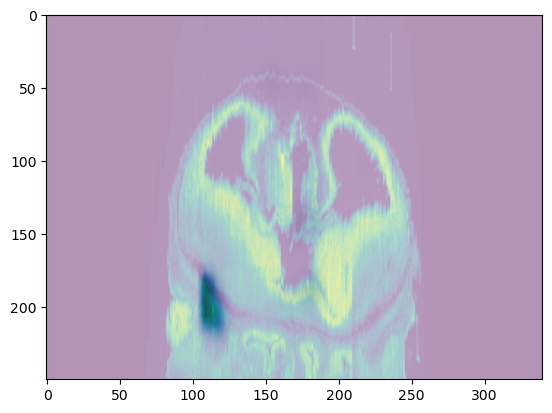

In [51]:
import SimpleITK as sitk
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
A = ct_scan.transpose(2,1,0) 
slice = 251
theta_deg = 0
J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:250,:]

gen = sitk.ReadImage("./gen-download/gen_list/Fgf15/energy.mhd")
total=sitk.Resample(gen,volume)
gen = sitk.GetArrayFromImage(total)
gen1 = gen.transpose(2,1,0) 
#gen1 = np.ma.masked_where(gen1 < 0., gen1)
gen = (gen1[slice][None] / np.mean(np.abs(gen1[slice]),keepdims=True)).astype(np.float64)
gen=gen[:,:250,:]
 
YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 
fig,ax = plt.subplots()
extentJ = STalign.extent_from_x((YJ,XJ))
#extentA = STalign.extent_from_x(xA[1:])
extentI = STalign.extent_from_x((YI,XI))
theta_deg = -(90+30)
ax.imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
ax.imshow((gen[0:1].transpose(1,2,0).squeeze()), extent=extentJ,cmap='PuBuGn',alpha =0.6)

In [ ]:
gen = sitk.ReadImage("./gen-download/gen_list/Zmat4/test.mhd")

In [152]:
temp=[]
for i in range(len(onlyfiles)):
    files=listdir(mypath+"/"+onlyfiles[i])
    for j in files:
        if ".mhd" in j :
            #print(mypath+"/"+onlyfiles[i]+"/"+j)
            gen = sitk.ReadImage(mypath+"/"+onlyfiles[i]+"/"+j)
            total=sitk.Resample(gen,volume)
            gen = sitk.GetArrayFromImage(total)
            gen1 = gen.transpose(2,1,0) 
            gen = (gen1[slice][None] / np.mean(np.abs(gen1[slice]),keepdims=True)).astype(np.float64)
            gen=gen[:,:250,:]
            temp.append(gen[0])

In [122]:
gen[0]

array([[ 0.        ,  0.        ,  0.        , ..., -1.40025783,
        -1.40025783, -1.40025783],
       [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
        -1.40025783, -1.40025783],
       [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
        -1.40025783, -1.40025783],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
        -1.40025783, -1.40025783],
       [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
        -1.40025783, -1.40025783],
       [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
        -1.40025783, -1.40025783]])

In [148]:
np.asarray(temp)



array([[[ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783]],

       [[ 0.        ,  0.        ,  0.        , ..., -1.30537343,
         -1.30537343, -1.30537343],
        [ 0.        ,  0.        ,  0.        , ..., -1.30537343,
         -1.30537343, -1.30537343],
        [ 0.        ,  0.        ,  0.        , ..., -1.30537343,
         -1.30537343, -1.30537343],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -

In [146]:
temp


[array([[ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783],
        [ 0.        ,  0.        ,  0.        , ..., -1.40025783,
         -1.40025783, -1.40025783]]),
 array([[ 0.        ,  0.        ,  0.        , ..., -1.30537343,
         -1.30537343, -1.30537343],
        [ 0.        ,  0.        ,  0.        , ..., -1.30537343,
         -1.30537343, -1.30537343],
        [ 0.        ,  0.        ,  0.        , ..., -1.30537343,
         -1.30537343, -1.30537343],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -